In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightautoml
from sklearn.model_selection import train_test_split
from autowoe import AutoWoE, ReportDeco
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import PrecisionRecallDisplay
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import numpy as np
import scipy.stats
import seaborn as sns
from matplotlib.pyplot import figure
from tqdm import tqdm
import torch

In [3]:
RANDOM_STATE = 42

# Загрузка данных

In [4]:
df_accepted = pd.read_csv('accepted_2007_to_2018q4/accepted_2007_to_2018Q4.csv')

### Удаление признаков, вызывающих утечку данных <br>и формирование таргета

In [5]:
features_to_drop = '''desc
funded_amnt
funded_amnt_inv
id
il_util
initial_list_status
installment
int_rate
issue_d
last_credit_pull_d
last_fico_range_high
last_fico_range_low
last_pymnt_amnt
last_pymnt_d
max_bal_bc
member_id
mths_since_last_delinq
mths_since_last_major_derog
mths_since_last_record
mths_since_rcnt_il
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
next_pymnt_d
out_prncp
out_prncp_inv
policy_code
pymnt_plan
recoveries
revol_bal
revol_util
sub_grade
term
tot_hi_cred_lim
total_pymnt
total_pymnt_inv
total_rec_int
total_rec_late_fee
total_rec_prncp
url
zip_code
revol_bal_joint 
sec_app_earliest_cr_line 
sec_app_inq_last_6mths 
hardship_flag
hardship_type
hardship_reason
hardship_status
deferral_term
hardship_amount
hardship_start_date
hardship_end_date
payment_plan_start_date
hardship_length
hardship_dpd
hardship_loan_status
orig_projected_additional_accrued_interest
hardship_payoff_balance_amount
hardship_last_payment_amount
disbursement_method
debt_settlement_flag
debt_settlement_flag_date
settlement_status
settlement_date
settlement_amount
settlement_percentage
settlement_term
'''.split()

features = list(set(df_accepted.columns) - set(features_to_drop))

In [6]:
df_accepted.groupby(by='loan_status').count()['loan_amnt']

loan_status
Charged Off                                             268559
Current                                                 878317
Default                                                     40
Does not meet the credit policy. Status:Charged Off        761
Does not meet the credit policy. Status:Fully Paid        1988
Fully Paid                                             1076751
In Grace Period                                           8436
Late (16-30 days)                                         4349
Late (31-120 days)                                       21467
Name: loan_amnt, dtype: int64

In [7]:
df_accepted['loan_status2'] = df_accepted['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1, 'Late (31-120 days)': 2})
df_accepted.loc[df_accepted['loan_status2'] == 2, 'loan_status2'] = ((pd.to_datetime(df_accepted['last_pymnt_d']).max() - pd.to_datetime(df_accepted['last_pymnt_d'])).dt.days > 90)
df_accepted = df_accepted[~df_accepted['loan_status2'].isna()].copy()

df_accepted = df_accepted[~((df_accepted['loan_status'] == 'Late (31-120 days)') & (df_accepted['loan_status2'] == 0))].copy()
df_accepted['target'] = df_accepted['loan_status2']
df_accepted.drop(columns='loan_status2', inplace=True)
df_accepted[['target', 'loan_status']].value_counts()

target  loan_status       
0.0     Fully Paid            1076751
1.0     Charged Off            268559
        Late (31-120 days)       3956
dtype: int64

# Разделение out_of_sample, out_of_time

In [8]:
df_accepted['issue_d'] = pd.to_datetime(df_accepted['issue_d'])

In [9]:
df_accepted.sort_values(by='issue_d', inplace=True)

In [10]:
df_accepted.drop(columns=list({'loan_status'} | set(features_to_drop)), inplace=True)

In [11]:
df_accepted.reset_index(drop=True, inplace=True)

In [12]:
df_accepted['target'] = df_accepted['target'].astype(int)

In [13]:
tmp = df_accepted.iloc[:int(0.85 * df_accepted.shape[0])].copy()
train, out_of_sample_test = train_test_split(
    tmp, 
    test_size = 0.15/0.85,
    stratify = tmp['target'] 
)

In [14]:
out_of_time_test = df_accepted.iloc[int(0.85 * df_accepted.shape[0]):].copy()

# Построение интерпретируемой модели

In [16]:
auto_woe_0 = AutoWoE(interpreted_model=True,
                     monotonic=False,
                     max_bin_count=5,
                     select_type=None,
                     pearson_th=0.9,
                     vif_th=10.,
                     imp_th=0,
                     th_const=32,
                     force_single_split=True,
                     th_nan=0.01,
                     th_cat=0.005,
                     cat_alpha=100,
                     cat_merge_to="to_woe_0",
                     nan_merge_to="to_woe_0",
                     imp_type="feature_imp",
                     regularized_refit=False,
                     p_val=0.05,
                     verbose=2
        )

auto_woe_0 = ReportDeco(auto_woe_0)

In [17]:
auto_woe_0.fit(
               train,
               target_name="target"
              )

dict_keys(['loan_amnt', 'grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'title', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'pub_rec', 'collection_recovery_fee', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_24m', 'all_util', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'mo_sin_old_rev_tl_op', 'mort_acc', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'total_bc_limit', 'total_il_high_credit_limit']) to selector !!!!!
Feature selection...
grade                  -0.801847
fico_range_low         -0.243642
acc_open_past_24mths   -0.503961
dti                    -0.336293
avg_cur_bal            -0.097297
verification_status    -0.185427
mort_acc               -0.242074
num_rev_tl_bal_gt_0    -0.195248
loan_amnt              -1.090393
title                  -0.226651
annual_

### Предсказания на тестовой выборке out_of_sample

In [18]:
test_prediction_oos = auto_woe_0.predict_proba(out_of_sample_test)
test_prediction_oos

array([0.08766527, 0.27577454, 0.1144113 , ..., 0.10266627, 0.29306026,
       0.04167264])

In [95]:
fpr, tpr, thresholds = roc_curve(out_of_sample_test['target'], test_prediction_oos)
gmean = np.sqrt(tpr * (1 - fpr))
threshold_first = round(thresholds[np.argmax(gmean)], ndigits = 4)
y_pred_simple_oos = np.where(test_prediction_oos > threshold_first, 1, 0)

In [91]:
print('Порог отсечения вероятности: ', threshold_first)

Порог отсечения вероятности:  0.2008


In [349]:
print('ROC-AUC: ', roc_auc_score(out_of_sample_test['target'].values, test_prediction_oos))
print('Accuracy: ', accuracy_score(out_of_sample_test['target'].values, y_pred_simple_oos))
print('F1: ', f1_score(out_of_sample_test['target'].values, y_pred_simple_oos))
print('Recall: ', recall_score(out_of_sample_test['target'].values, y_pred_simple_oos))
print('Precision: ', precision_score(out_of_sample_test['target'].values, y_pred_simple_oos))

ROC-AUC:  0.7128200499597116
Accuracy:  0.6430999555313998
F1:  0.43000197277569535
Recall:  0.6779804414362853
Precision:  0.3148443458365111


### Формирование отчета

In [25]:
report_params = {"output_path": "SimpleModel", # folder for report generation
                 "report_name": "WHITEBOX REPORT",
                 "report_version_id": 1,
                 "city": "Moscow",
                 "model_aim": "Project",
                 "model_name": "HR model",
                 "zakazchik": "FTIADUS",
                 "high_level_department": "Ai Lab",
                 "ds_name": "Btbpanda",
                 "target_descr": "Candidate will work for the company",
                 "non_target_descr": "Candidate will work for the company"}

auto_woe_0.generate_report(report_params, )

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


### Предсказания на тестовой выборке out_of_time

In [36]:
test_prediction_oot = auto_woe_0.predict_proba(out_of_time_test)
test_prediction_oot

array([0.1332444 , 0.09953046, 0.33463001, ..., 0.15026593, 0.34703638,
       0.23658348])

In [346]:
y_pred_simple_oot = np.where(test_prediction_oot > threshold_first, 1, 0)

In [348]:
print('ROC-AUC: ', roc_auc_score(out_of_time_test['target'].values, test_prediction_oot))
print('Accuracy: ', accuracy_score(out_of_time_test['target'].values, y_pred_simple_oot))
print('F1: ', f1_score(out_of_time_test['target'].values, y_pred_simple_oot))
print('Recall: ', recall_score(out_of_time_test['target'].values, y_pred_simple_oot))
print('Precision: ', precision_score(out_of_time_test['target'].values, y_pred_simple_oot))

ROC-AUC:  0.6987929082181299
Accuracy:  0.5866940066208804
F1:  0.442975008490321
Recall:  0.7426651185638369
Precision:  0.3156141765905964


### Метрики на обучающей выборке

In [351]:
preds_train_logreg = auto_woe_0.predict_proba(train)
y_pred_simple_train = np.where(preds_train_logreg > threshold_first, 1, 0)

In [353]:
print('ROC-AUC: ', roc_auc_score(train['target'].values, preds_train_logreg))
print('F1: ', f1_score(train['target'].values, y_pred_simple_train))
print('Precision: ', precision_score(train['target'].values, y_pred_simple_train))
print('Recall: ', recall_score(train['target'].values, y_pred_simple_train))
print('Accuracy: ', accuracy_score(train['target'].values, y_pred_simple_train))

ROC-AUC:  0.7100668963986645
F1:  0.4263306414026287
Precision:  0.31248990665676174
Recall:  0.6706497744505231
Accuracy:  0.6416198863720585


# Продвинутая модель

In [28]:
N_THREADS = 4
N_FOLDS = 5
TEST_SIZE = 0.2
TIMEOUT = 1800
TARGET_NAME = 'target'

In [29]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [30]:
task = Task('binary')

In [31]:
roles = {
    'target': TARGET_NAME
}

In [357]:
from lightautoml.report.report_deco import ReportDeco

In [358]:
RD = ReportDeco(output_path = 'ImprovedModel')
automl = RD(TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
))

### Обучение продвинутой модели

In [359]:
train_prediction_improved =  automl.fit_predict(train, roles = roles, verbose = 1)
train_prediction_improved

[20:37:56] Stdout logging level is INFO.
[20:37:56] Task: binary

[20:37:56] Start automl preset with listed constraints:
[20:37:56] - time: 1800.00 seconds
[20:37:56] - CPU: 4 cores
[20:37:56] - memory: 16 GB

[20:37:56] Train data shape: (944486, 83)

[20:38:13] Layer 1 train process start. Time left 1783.25 secs
[20:39:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[20:40:39] Time limit exceeded after calculating fold 0

[20:40:39] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9063640817641497
[20:40:39] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[20:40:39] Time left 1636.48 secs

[20:42:46] Selector_LightGBM fitting and predicting completed
[20:43:33] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[20:46:34] Time limit exceeded after calculating fold 1

[20:46:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9153824722861285
[20:46:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[20:46:35] Start fitting Lvl_0_Pipe_1_Mod_2_Ca

array([[0.26528457],
       [0.02451689],
       [0.05058359],
       ...,
       [0.07071802],
       [       nan],
       [0.15834713]], dtype=float32)

### Предсказания на выборке out_of_sample

In [361]:
test_prediction_oos_improved =  automl.predict(out_of_sample_test)
test_prediction_oos_improved

array([[0.03313808],
       [0.9994396 ],
       [0.03908609],
       ...,
       [0.02723163],
       [0.99935246],
       [0.0343206 ]], dtype=float32)

In [362]:
fpr, tpr, thresholds = roc_curve(out_of_sample_test['target'].values, test_prediction_oos_improved.data[:, 0])
gmean = np.sqrt(tpr * (1 - fpr))
threshold_first_improved = round(thresholds[np.argmax(gmean)], ndigits = 4)
y_pred_improved_oos = np.where(test_prediction_oos_improved.data[:, 0] > threshold_first_improved, 1, 0)
print('Порог отсечения вероятности: ', threshold_first_improved)

Порог отсечения вероятности:  0.1684


In [363]:
print('ROC-AUC: ', roc_auc_score(out_of_sample_test['target'].values, test_prediction_oos_improved.data[:, 0]))
print('Accuracy: ', accuracy_score(out_of_sample_test['target'].values, y_pred_improved_oos))
print('F1: ', f1_score(out_of_sample_test['target'].values, y_pred_improved_oos))
print('Recall: ', recall_score(out_of_sample_test['target'].values, y_pred_improved_oos))
print('Precision: ', precision_score(out_of_sample_test['target'].values, y_pred_improved_oos))

ROC-AUC:  0.9171574769238373
Accuracy:  0.9048717822026779
F1:  0.7613511000929656
Recall:  0.7642023539950731
Precision:  0.7585210432720806


### Предсказания на выборке out_of_time

In [365]:
test_prediction_oot_improved =  automl.predict(out_of_time_test)
test_prediction_oot_improved

array([[0.03171276],
       [0.03743827],
       [0.11575525],
       ...,
       [0.07155132],
       [0.12498768],
       [0.07751708]], dtype=float32)

In [404]:
y_pred_improved_oot = np.where(test_prediction_oot_improved.data[:, 0] > threshold_first_improved, 1, 0)

In [405]:
print('ROC-AUC: ', roc_auc_score(out_of_time_test['target'].values, test_prediction_oot_improved.data[:, 0]))
print('Accuracy: ', accuracy_score(out_of_time_test['target'].values, y_pred_improved_oot))
print('F1: ', f1_score(out_of_time_test['target'].values, y_pred_improved_oot))
print('Recall: ', recall_score(out_of_time_test['target'].values, y_pred_improved_oot))
print('Precision: ', precision_score(out_of_time_test['target'].values, y_pred_improved_oot))

ROC-AUC:  0.8402754666086917
Accuracy:  0.8289441177923811
F1:  0.6180072823568354
Recall:  0.6253070155852275
Precision:  0.6108760143093971


### Статистики по обучающей выборке

In [368]:
y_pred_improved_train = np.where(train_prediction_improved.data[:, 0] > threshold_first_improved, 1, 0)

In [370]:
# Для train некоторые предикты обращаются в nan из-за маленького числа и потери точности,
# поэтому заменим их нулями
train_prediction_improved.data[:, 0]

array([0.26528457, 0.02451689, 0.05058359, ..., 0.07071802,        nan,
       0.15834713], dtype=float32)

In [371]:
tmp =  automl.predict(df_accepted)

In [376]:
df_accepted['train_pred'] = tmp.data[:, 0]

In [380]:
train_prediction_improved = df_accepted.iloc[train.index, :]['train_pred']

In [381]:
y_pred_improved_train = np.where(train_prediction_improved> threshold_first_improved, 1, 0)

In [382]:
print('ROC-AUC: ', roc_auc_score(train['target'].values, train_prediction_improved))
print('Accuracy: ', accuracy_score(train['target'].values, y_pred_improved_train))
print('F1: ', f1_score(train['target'].values, y_pred_improved_train))
print('Recall: ', recall_score(train['target'].values, y_pred_improved_train))
print('Precision: ', precision_score(train['target'].values, y_pred_improved_train))

ROC-AUC:  0.9336390924215596
Accuracy:  0.9134947474075846
F1:  0.7834770141596064
Recall:  0.7881914451162939
Precision:  0.7788186449875921


## Модель стабильно работает на отложенных выборках, демонстрирует высокое качество в разные периоды времени.

## Сохранение прогнозов модели

In [101]:
preds_full_logreg = auto_woe_0.predict_proba(df_accepted)
y_pred_full_logreg = np.where(preds_full_logreg > threshold_first, 1, 0)

In [383]:
preds_full_improved =  automl.predict(df_accepted)
y_pred_full_improved = np.where(preds_full_improved.data[:, 0] > threshold_first_improved, 1, 0)

In [384]:
df_with_preds = pd.read_csv('accepted_2007_to_2018q4/accepted_2007_to_2018Q4.csv')

df_with_preds['loan_status2'] = df_with_preds['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1, 'Late (31-120 days)': 2})
df_with_preds.loc[df_with_preds['loan_status2'] == 2, 'loan_status2'] = ((pd.to_datetime(df_with_preds['last_pymnt_d']).max() - pd.to_datetime(df_with_preds['last_pymnt_d'])).dt.days > 90)
df_with_preds = df_with_preds[~df_with_preds['loan_status2'].isna()].copy()

df_with_preds = df_with_preds[~((df_with_preds['loan_status'] == 'Late (31-120 days)') & (df_with_preds['loan_status2'] == 0))].copy()
df_with_preds['target'] = df_with_preds['loan_status2']
df_with_preds.drop(columns='loan_status2', inplace=True)
df_with_preds['preds_logreg'] = y_pred_full_logreg
df_with_preds['preds_logreg_proba'] = preds_full_logreg
df_with_preds['preds_improved'] = y_pred_full_improved
df_with_preds['preds_improved_proba'] = preds_full_improved.data[:, 0]

In [385]:
df_with_preds.to_csv('data_with_preds.csv', index=False)

# Расчет ожидаемых и неожидаемых потерь

### Предположение о независимости дефолтов по отдельным кредитам

In [386]:
df_filtered = df_with_preds[pd.to_datetime(df_with_preds['issue_d'])>=pd.to_datetime('2017-01-01')].copy()

In [387]:
df_filtered['losses_logreg'] = df_filtered['funded_amnt'] * df_filtered['preds_logreg_proba']
df_filtered['losses_improved'] = df_filtered['funded_amnt'] * df_filtered['preds_improved_proba']

In [388]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

#### Статистики для интерпретируемой модели

In [389]:
expected_losses_logreg = df_filtered['losses_logreg'].mean()
conf_int_logreg = mean_confidence_interval(df_filtered['losses_logreg'])
print(f'Ожидаемые потери (Мат. ожидание потерь): {expected_losses_logreg:.3f}')
print(f'99% доверительный интервал для среднего: [{conf_int_logreg[1]:.3f}, {conf_int_logreg[2]:.3f}]')

Ожидаемые потери (Мат. ожидание потерь): 3047.723
99% доверительный интервал для среднего: [3031.621, 3063.826]


In [390]:
var_expected_logreg = np.quantile(df_filtered['losses_logreg'], q=0.999)
var_confint_logreg = scipy.stats.mstats.mquantiles_cimj(df_filtered['losses_logreg'], prob=[0.999], alpha=0.05, axis=None)
print(f'Неожидаемые потери (VaR на уровне 99.9%): {var_expected_logreg:.3f}')
print(f'Неожидаемые потери (Доверительный интервал для VaR): [{var_confint_logreg[0][0]:.3f}, {var_confint_logreg[1][0]:.3f}]')

Неожидаемые потери (VaR на уровне 99.9%): 19762.415
Неожидаемые потери (Доверительный интервал для VaR): [19524.138, 20013.633]


In [391]:
necessary_cap_logreg = var_expected_logreg - expected_losses_logreg
nc_int_logreg = (var_confint_logreg[0][0] - conf_int_logreg[1], var_confint_logreg[1][0] - conf_int_logreg[2])
print(f'Необходимый капитал: {necessary_cap_logreg:.3f}')
print(f'Доверительный интервал необходимого капитал: [{nc_int_logreg[0]:.3f}, {nc_int_logreg[1]:.3f}]')

Необходимый капитал: 16714.692
Доверительный интервал необходимого капитал: [16492.517, 16949.807]


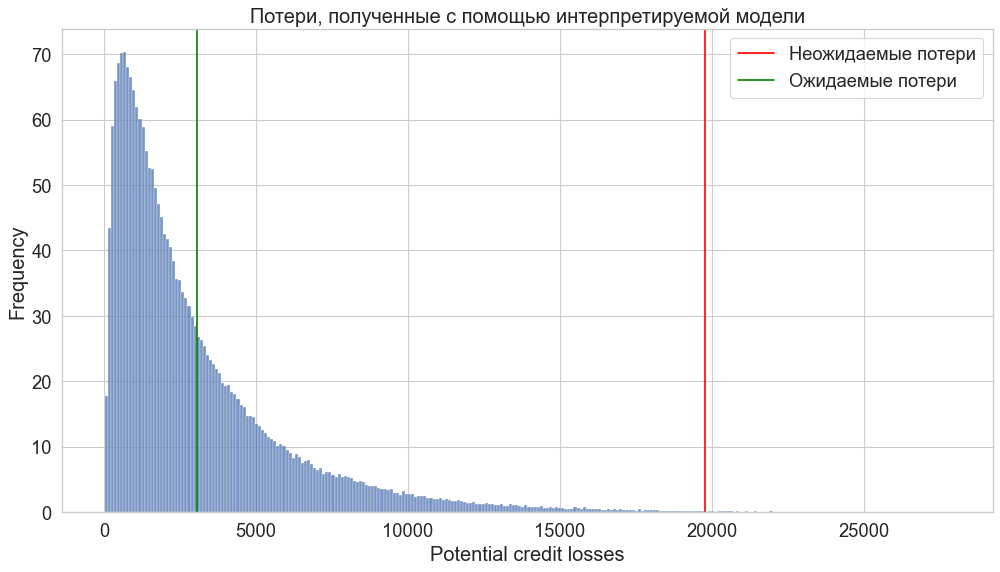

In [392]:
figure(figsize=(15, 8), dpi=80)
sns.histplot(df_filtered['losses_logreg'], stat='frequency')
plt.xlabel('Potential credit losses')
plt.axvline(x=var_expected_logreg, color='red', label='Неожидаемые потери')
plt.axvline(x=expected_losses_logreg, color='green', label='Ожидаемые потери')
plt.title('Потери, полученные с помощью интерпретируемой модели')
plt.legend(loc=1)
plt.show()

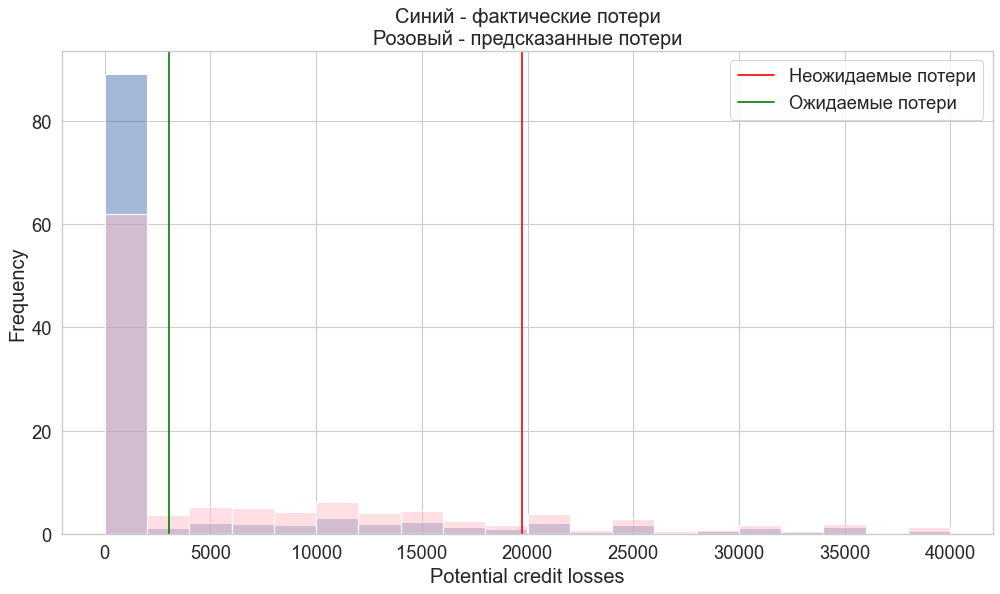

In [393]:
figure(figsize=(15, 8), dpi=80)
sns.histplot(
    df_filtered['target'] * df_filtered['funded_amnt'], 
    stat='frequency', 
    bins=20, 
    alpha=0.5)
sns.histplot(
    df_filtered['preds_logreg'] * df_filtered['funded_amnt'], 
    stat='frequency', 
    bins=20, 
    color='pink', 
    alpha=0.5)
plt.xlabel('Potential credit losses')
plt.axvline(x=var_expected_logreg, color='red', label='Неожидаемые потери')
plt.axvline(x=expected_losses_logreg, color='green', label='Ожидаемые потери')
plt.title('Синий - фактические потери\nРозовый - предсказанные потери')
plt.legend()
plt.show()

#### Статистики для продвинутой модели

In [394]:
expected_losses_improved = df_filtered['losses_improved'].mean()
conf_int_improved = mean_confidence_interval(df_filtered['losses_improved'])
print(f'Ожидаемые потери (Мат. ожидание потерь): {expected_losses_improved:.3f}')
print(f'99% доверительный интервал для среднего: [{conf_int_improved[1]:.3f}, {conf_int_improved[2]:.3f}]')

Ожидаемые потери (Мат. ожидание потерь): 3044.397
99% доверительный интервал для среднего: [3011.873, 3076.921]


In [395]:
var_expected_improved = np.quantile(df_filtered['losses_improved'], q=0.999)
var_confint_improved = scipy.stats.mstats.mquantiles_cimj(df_filtered['losses_improved'], prob=[0.999], alpha=0.05, axis=None)
print(f'Неожидаемые потери (VaR на уровне 99.9%): {var_expected_improved:.3f}')
print(f'Неожидаемые потери (Доверительный интервал для VaR): [{var_confint_improved[0][0]:.3f}, {var_confint_improved[1][0]:.3f}]')

Неожидаемые потери (VaR на уровне 99.9%): 39978.777
Неожидаемые потери (Доверительный интервал для VaR): [39978.059, 39979.502]


In [396]:
necessary_cap_improved = var_expected_improved - expected_losses_improved
nc_int_improved = (var_confint_improved[0][0] - conf_int_improved[1], var_confint_improved[1][0] - conf_int_improved[2])
print(f'Необходимый капитал: {necessary_cap_improved:.3f}')
print(f'Доверительный интервал необходимого капитал: [{nc_int_improved[0]:.3f}, {nc_int_improved[1]:.3f}]')

Необходимый капитал: 36934.381
Доверительный интервал необходимого капитал: [36966.186, 36902.582]


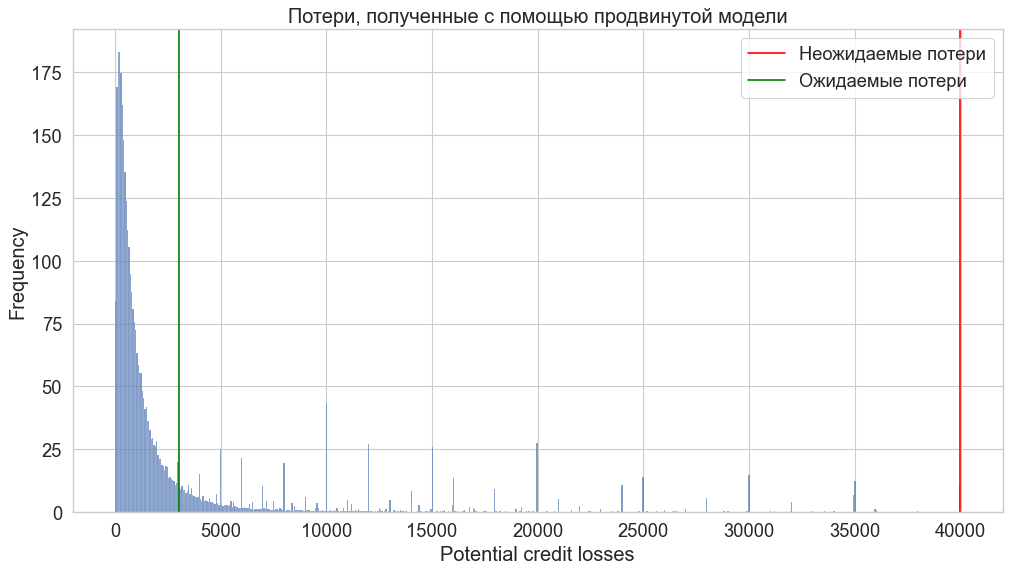

In [397]:
figure(figsize=(15, 8), dpi=80)
sns.histplot(df_filtered['losses_improved'], stat='frequency')
plt.xlabel('Potential credit losses')

plt.axvline(x=var_expected_improved, color='red', label='Неожидаемые потери')
plt.axvline(x=expected_losses_improved, color='green', label='Ожидаемые потери')
plt.title('Потери, полученные с помощью продвинутой модели')
plt.legend(loc=1)
plt.show()

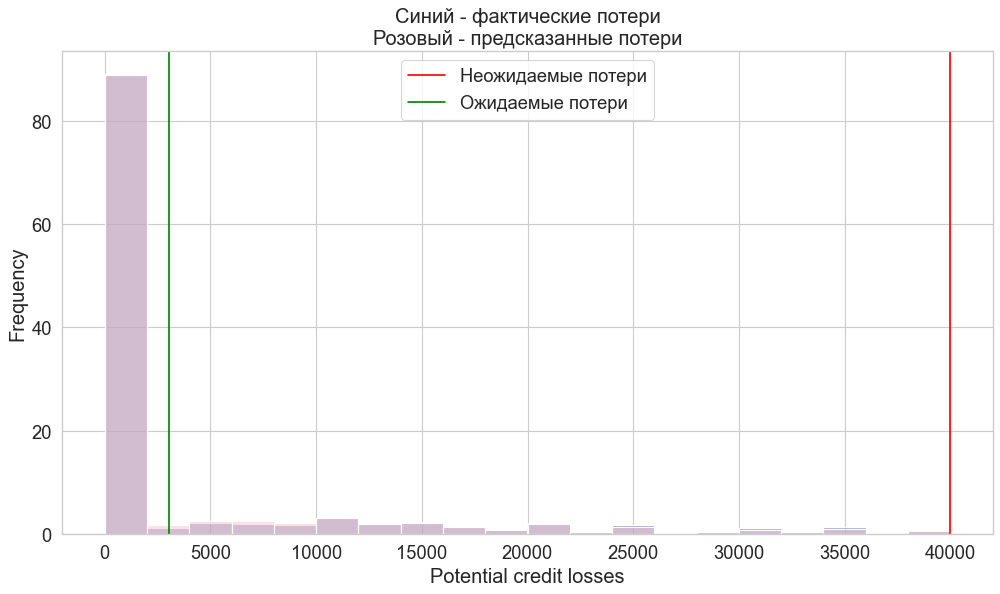

In [398]:
figure(figsize=(15, 8), dpi=80)
sns.histplot(
    df_filtered['target'] * df_filtered['funded_amnt'], 
    stat='frequency', 
    bins=20, 
    alpha=0.5)
sns.histplot(
    df_filtered['preds_improved'] * df_filtered['funded_amnt'], 
    stat='frequency', 
    bins=20, 
    color='pink', 
    alpha=0.5)
plt.xlabel('Potential credit losses')
plt.axvline(x=var_expected_improved, color='red', label='Неожидаемые потери')
plt.axvline(x=expected_losses_improved, color='green', label='Ожидаемые потери')
plt.title('Синий - фактические потери\nРозовый - предсказанные потери')
plt.legend()
plt.show()

# Расчет порога отсечения

### Интерпретируемая модель

In [302]:
df_threshold = df_with_preds.iloc[train.index]
df_threshold['term'] = df_threshold['term'].apply(lambda x: x.split()[0]).astype(int)

In [303]:
thresholds = np.linspace(0, 1, 150)
profits_logreg = []
best_profit_logreg = float('-inf')
for threshold in tqdm(thresholds):
    df_threshold['threshold_pred_logreg'] = np.where(df_threshold['preds_logreg_proba'] > threshold, 1, 0)
    df_good_clients = df_threshold[
        (df_threshold['threshold_pred_logreg']==0) &
        (df_threshold['target']==0)
    ]
    revenue = sum(df_good_clients['installment'] * df_good_clients['term'] - df_good_clients['loan_amnt'])
    df_bad_clients = df_threshold[
        (df_threshold['threshold_pred_logreg']==0) &
        (df_threshold['target']==1)
    ]
    loss = sum(df_bad_clients['loan_amnt'])
    profits_logreg.append(revenue - loss)
    if revenue - loss > best_profit_logreg:
        best_profit_logreg = revenue - loss
        best_threshold_logreg = threshold

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [04:18<00:00,  1.72s/it]


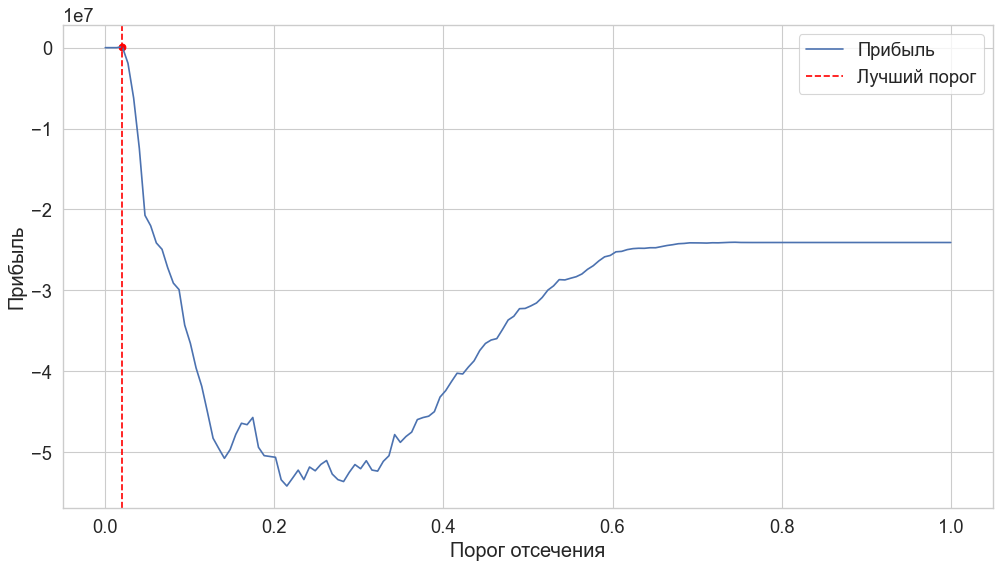

Прибыль при лучшем пороге: 110560.07999999844
Лучший порог: 0.020


In [304]:
figure(figsize=(15, 8), dpi=80)
plt.plot(thresholds, profits_logreg, label='Прибыль')
plt.scatter(best_threshold_logreg, best_profit_logreg, color='red')
plt.axvline(x=best_threshold_logreg, linestyle='--',color='red', label='Лучший порог')
plt.xlabel('Порог отсечения')
plt.ylabel('Прибыль')
plt.legend()
plt.show()
print(f'Прибыль при лучшем пороге: {best_profit_logreg}\nЛучший порог: {best_threshold_logreg:.3f}')

### Продвинутая модель

In [401]:
thresholds = np.linspace(0, 1, 150)
profits_improved = []
best_profit_improved = float('-inf')
for threshold in tqdm(thresholds):
    df_threshold['threshold_pred_improved'] = np.where(df_threshold['preds_improved_proba'] > threshold, 1, 0)
    df_good_clients = df_threshold[
        (df_threshold['threshold_pred_improved']==0) &
        (df_threshold['target']==0)
    ]
    revenue = sum(df_good_clients['installment'] * df_good_clients['term'] - df_good_clients['loan_amnt'])
    df_bad_clients = df_threshold[
        (df_threshold['threshold_pred_improved']==0) &
        (df_threshold['target']==1)
    ]
    loss = sum(df_bad_clients['loan_amnt'])
    profits_improved.append(revenue - loss)
    if revenue - loss > best_profit_improved:
        best_profit_improved = revenue - loss
        best_threshold_improved = threshold

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [04:17<00:00,  1.72s/it]


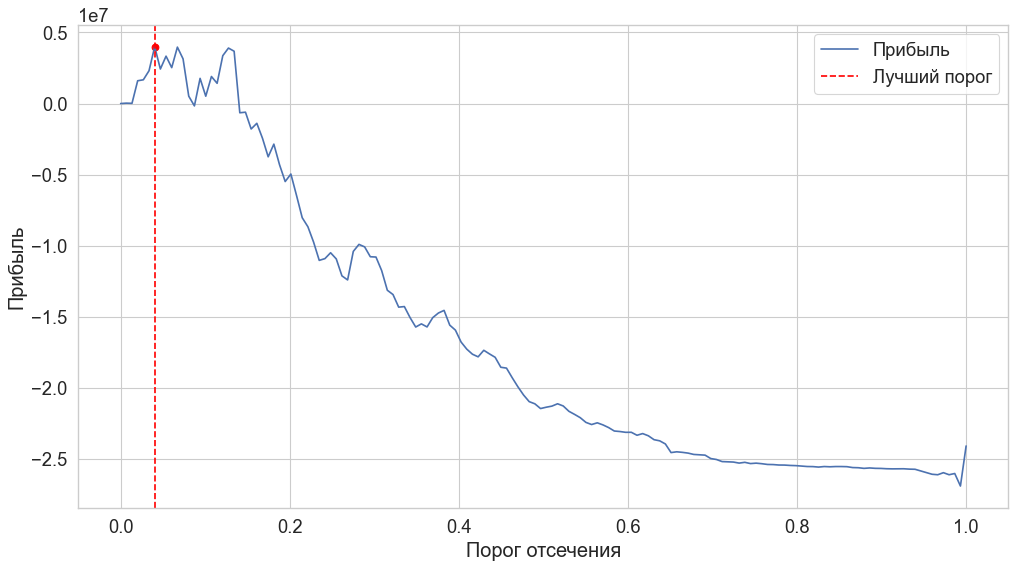

Прибыль при лучшем пороге: 3994269.399997592
Лучший порог: 0.040


In [402]:
figure(figsize=(15, 8), dpi=80)
plt.plot(thresholds, profits_improved, label='Прибыль')
plt.scatter(best_threshold_improved, best_profit_improved, color='red')
plt.axvline(x=best_threshold_improved, linestyle='--',color='red', label='Лучший порог')
plt.xlabel('Порог отсечения')
plt.ylabel('Прибыль')
plt.legend()
plt.show()
print(f'Прибыль при лучшем пороге: {best_profit_improved}\nЛучший порог: {best_threshold_improved:.3f}')

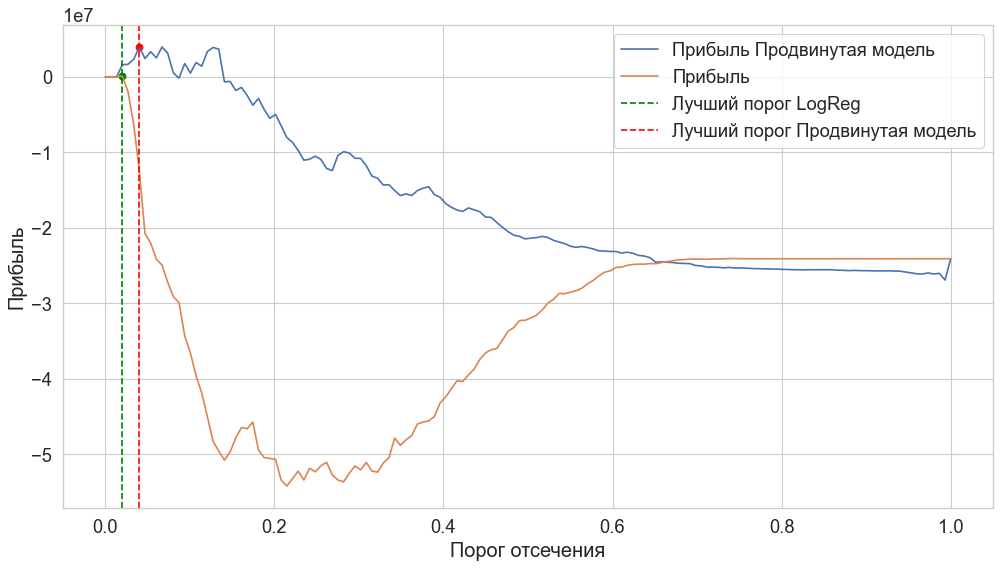

Прибыль при лучшем пороге LogReg: 110560.07999999844
Лучший порог LogReg: 0.020
Прибыль при лучшем пороге Продвинутая модель: 3994269.399997592
Лучший порог Продвинутая модель: 0.040


In [406]:
figure(figsize=(15, 8), dpi=80)
plt.plot(thresholds, profits_improved, label='Прибыль Продвинутая модель')
plt.plot(thresholds, profits_logreg, label='Прибыль')
plt.scatter(best_threshold_logreg, best_profit_logreg, color='green')
plt.axvline(x=best_threshold_logreg, linestyle='--',color='green', label='Лучший порог LogReg')
plt.scatter(best_threshold_improved, best_profit_improved, color='red')
plt.axvline(x=best_threshold_improved, linestyle='--',color='red', label='Лучший порог Продвинутая модель')
plt.xlabel('Порог отсечения')
plt.ylabel('Прибыль')
plt.legend()
plt.show()

print(f'Прибыль при лучшем пороге LogReg: {best_profit_logreg}\nЛучший порог LogReg: {best_threshold_logreg:.3f}')
print(f'Прибыль при лучшем пороге Продвинутая модель: {best_profit_improved}\nЛучший порог Продвинутая модель: {best_threshold_improved:.3f}')